In [84]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow import keras
import sys
import PIL
import os
import tensorflow.keras.backend as K
import sys
sys.path.append('../scripts/helper_functions_cv/tensorflow_helpers/')
from gpu_starter_mirror_strategy import start_gpus
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
strategy, REPLICAS, AUTO = start_gpus([0])

2023-03-07 17:41:36.429817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 17:41:36.488807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 17:41:36.490202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 17:41:36.492219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Returning objects as strategy, replicas and auto in same order.


In [4]:
train_csv = pd.read_csv('../data/train.csv')

In [5]:
train_csv.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [8]:
train_csv['updated_paths'] = train_csv['image'].progress_apply(lambda x: '../data/train_images/' + x)

100%|██████████| 18632/18632 [00:00<00:00, 1003921.64it/s]


In [10]:
train_csv.head()

,image,labels,updated_paths
0,800113bb65efe69e.jpg,healthy,../data/train_images/800113bb65efe69e.jpg
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,../data/train_images/8002cb321f8bfcdf.jpg
2,80070f7fb5e2ccaa.jpg,scab,../data/train_images/80070f7fb5e2ccaa.jpg
3,80077517781fb94f.jpg,scab,../data/train_images/80077517781fb94f.jpg
4,800cbf0ff87721f8.jpg,complex,../data/train_images/800cbf0ff87721f8.jpg


In [12]:
def check_paths(csv_file):
    paths = csv_file['updated_paths'].values.tolist()
    for path in paths:
        assert os.path.exists(path) == True, 'Path does not exist.'
check_paths(train_csv)

In [62]:
def plot_grpahs(csv_file):
    diseases = csv_file['labels'].value_counts().keys()
    disease_count = csv_file['labels'].value_counts().values
    percentages = [round((x / sum(disease_count)), 2) * 100 for x in disease_count]
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (25,15)
    bar_var = plt.bar(diseases, disease_count)
    for p in range(len(bar_var)):
        height = bar_var[p].get_height()
        ax.annotate('{}'.format(percentages[p]),
            xy=(bar_var[p].get_x() + bar_var[p].get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center', va='bottom')

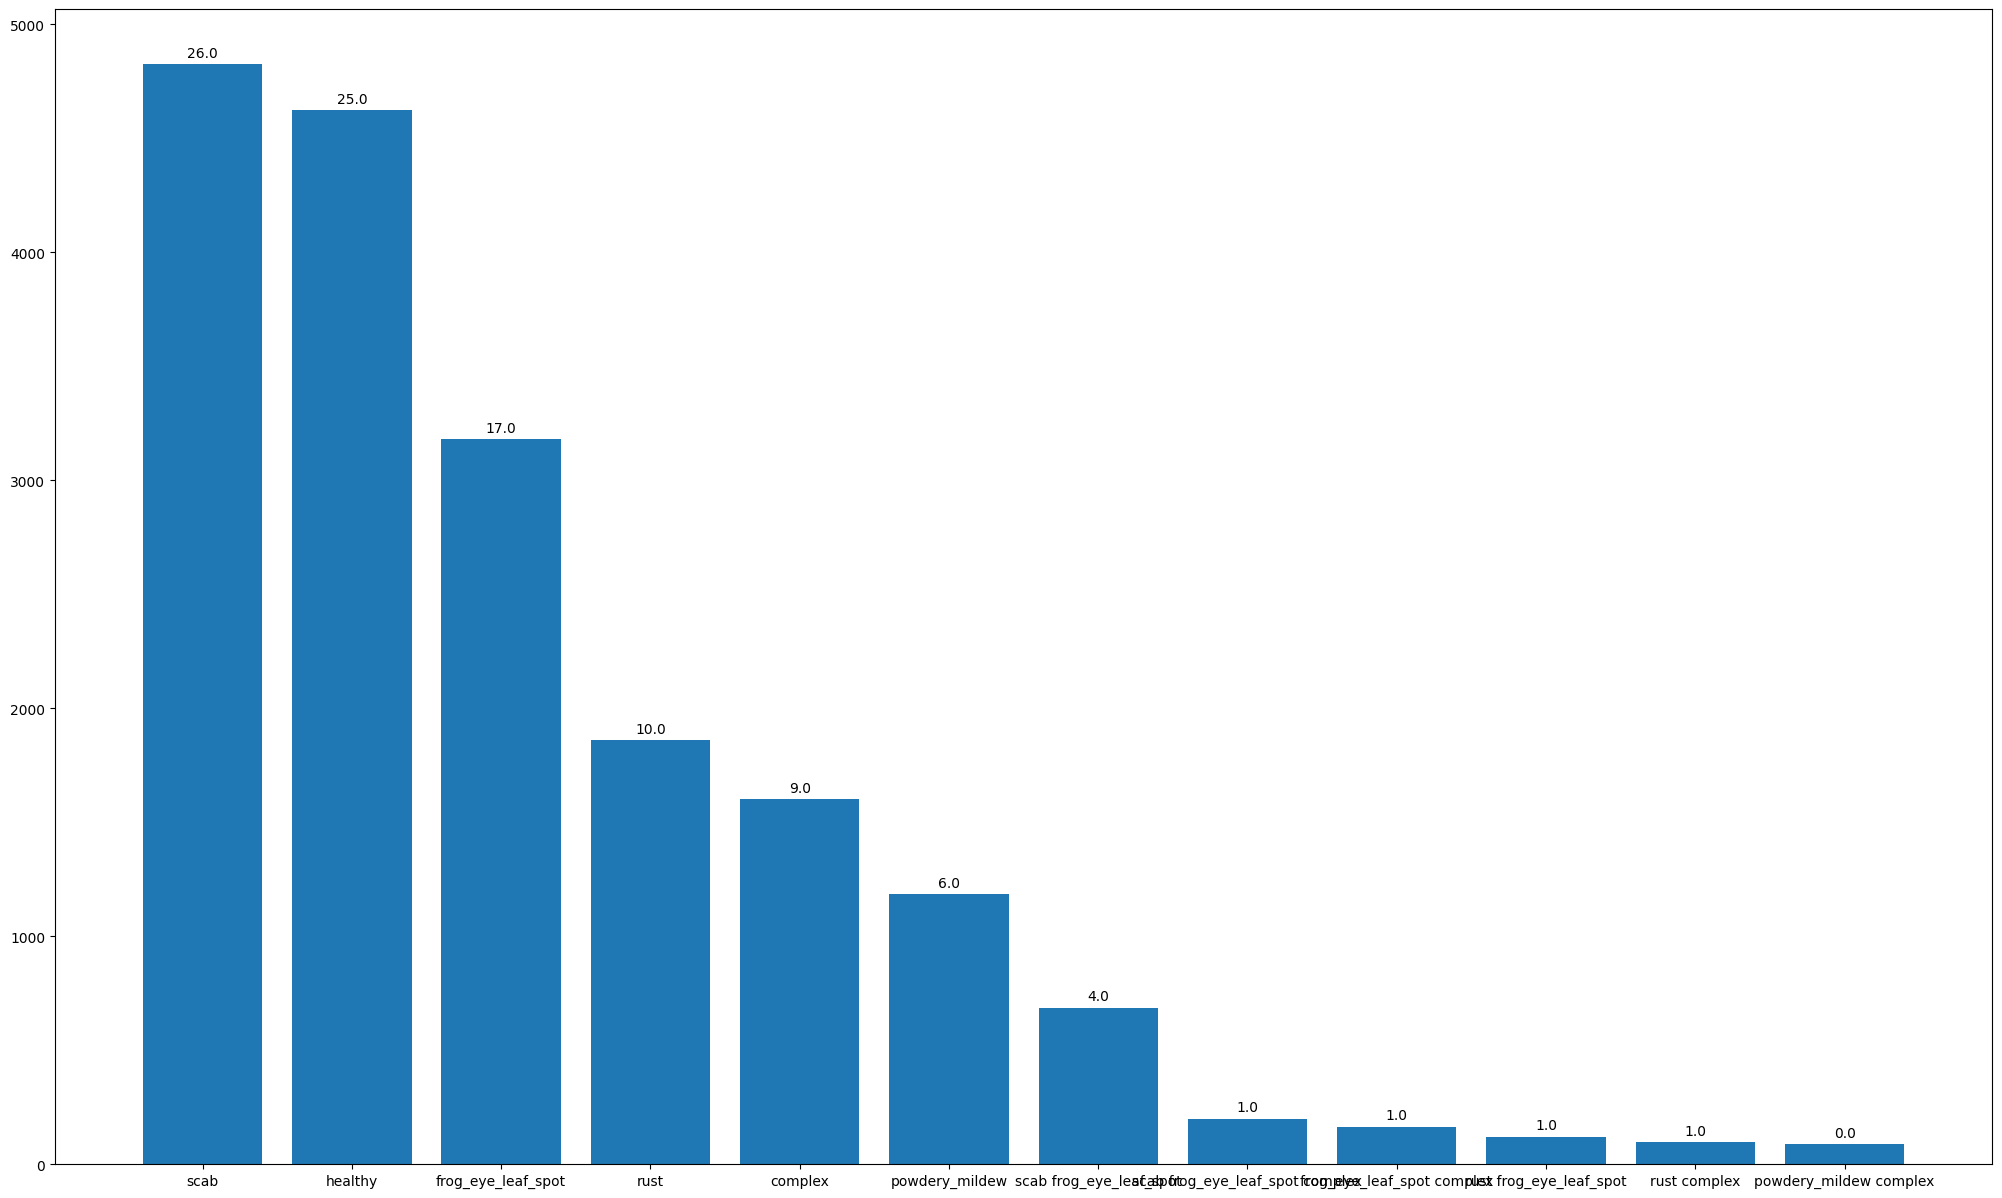

In [63]:
plot_grpahs(train_csv)

In [101]:
def label_encoders(csv_file):
    labels = csv_file['labels'].values.tolist()
    label_encoder = LabelEncoder()
    transformed = label_encoder.fit_transform(labels)
    return transformed, label_encoder

In [104]:
label_encoded, label_transformer = label_encoders(train_csv)
train_csv['labels_encoded'] = label_encoded

In [106]:
def split_datasets(csv_file, test_size):
    train, test = train_test_split(csv_file, test_size=test_size, random_state=42)
    train, val = train_test_split(csv_file, test_size=test_size, random_state=42)
    return train, val, test

In [107]:
train, val, test = split_datasets(train_csv, 0.08)

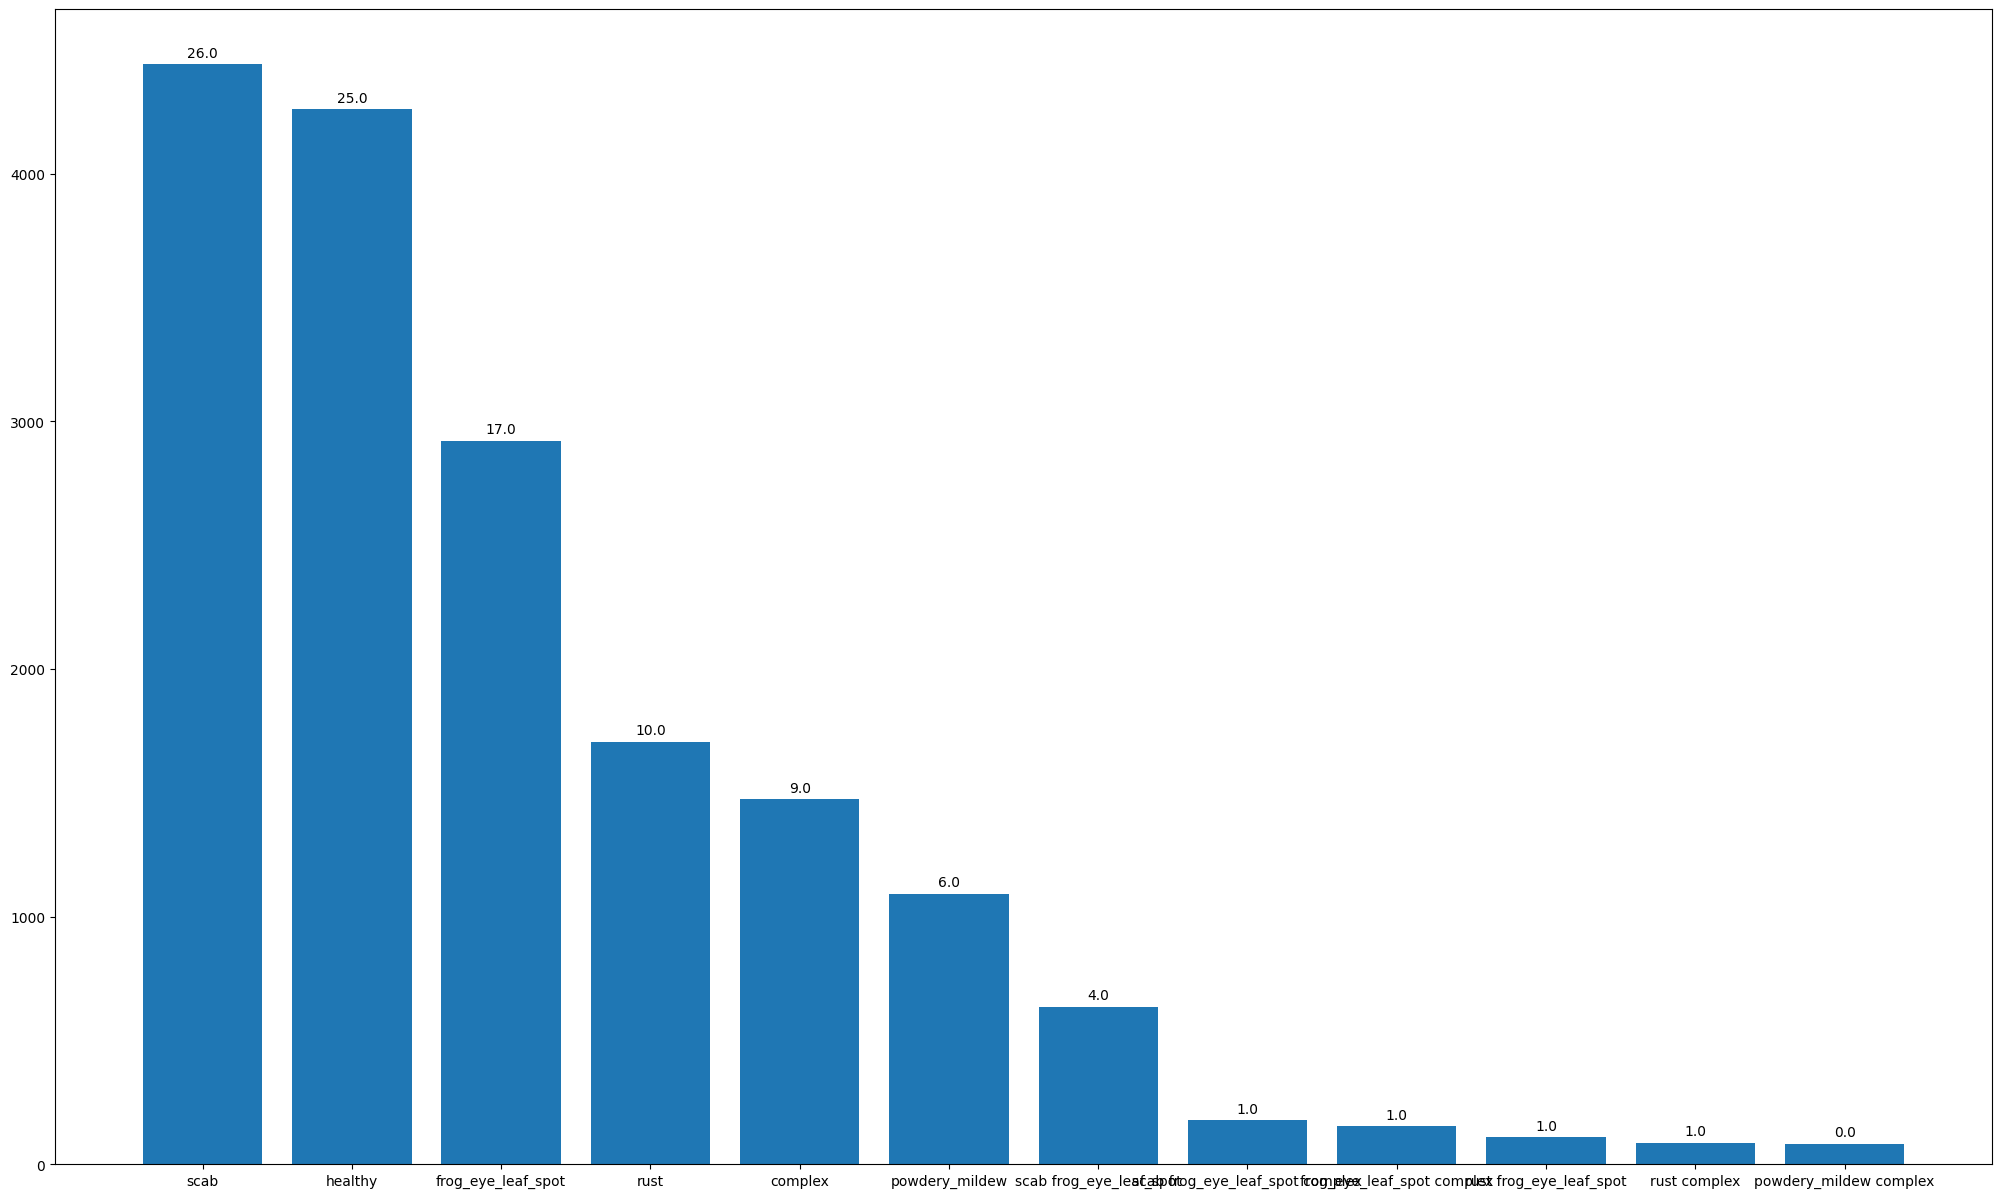

In [108]:
plot_grpahs(train)

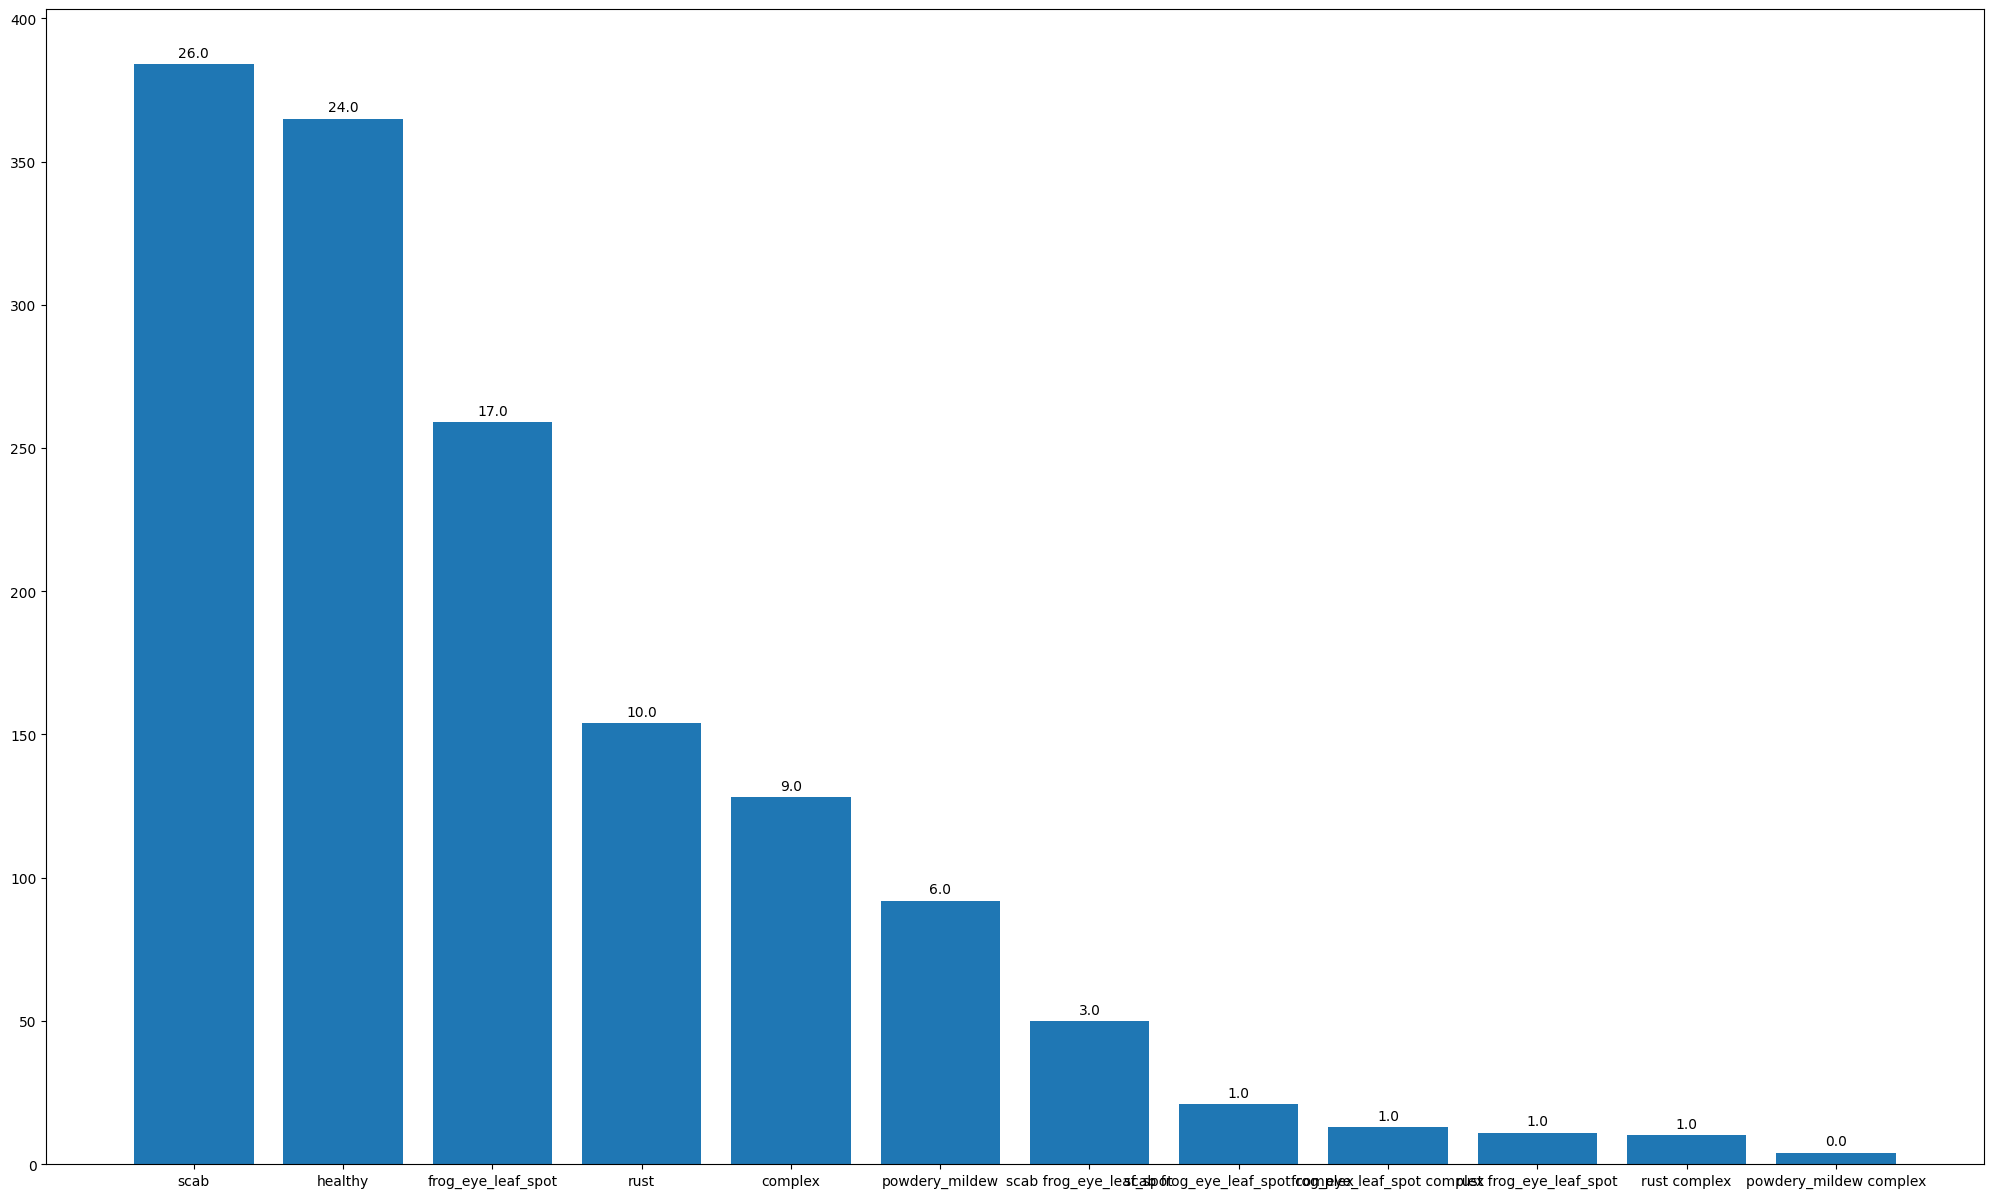

In [109]:
plot_grpahs(val)

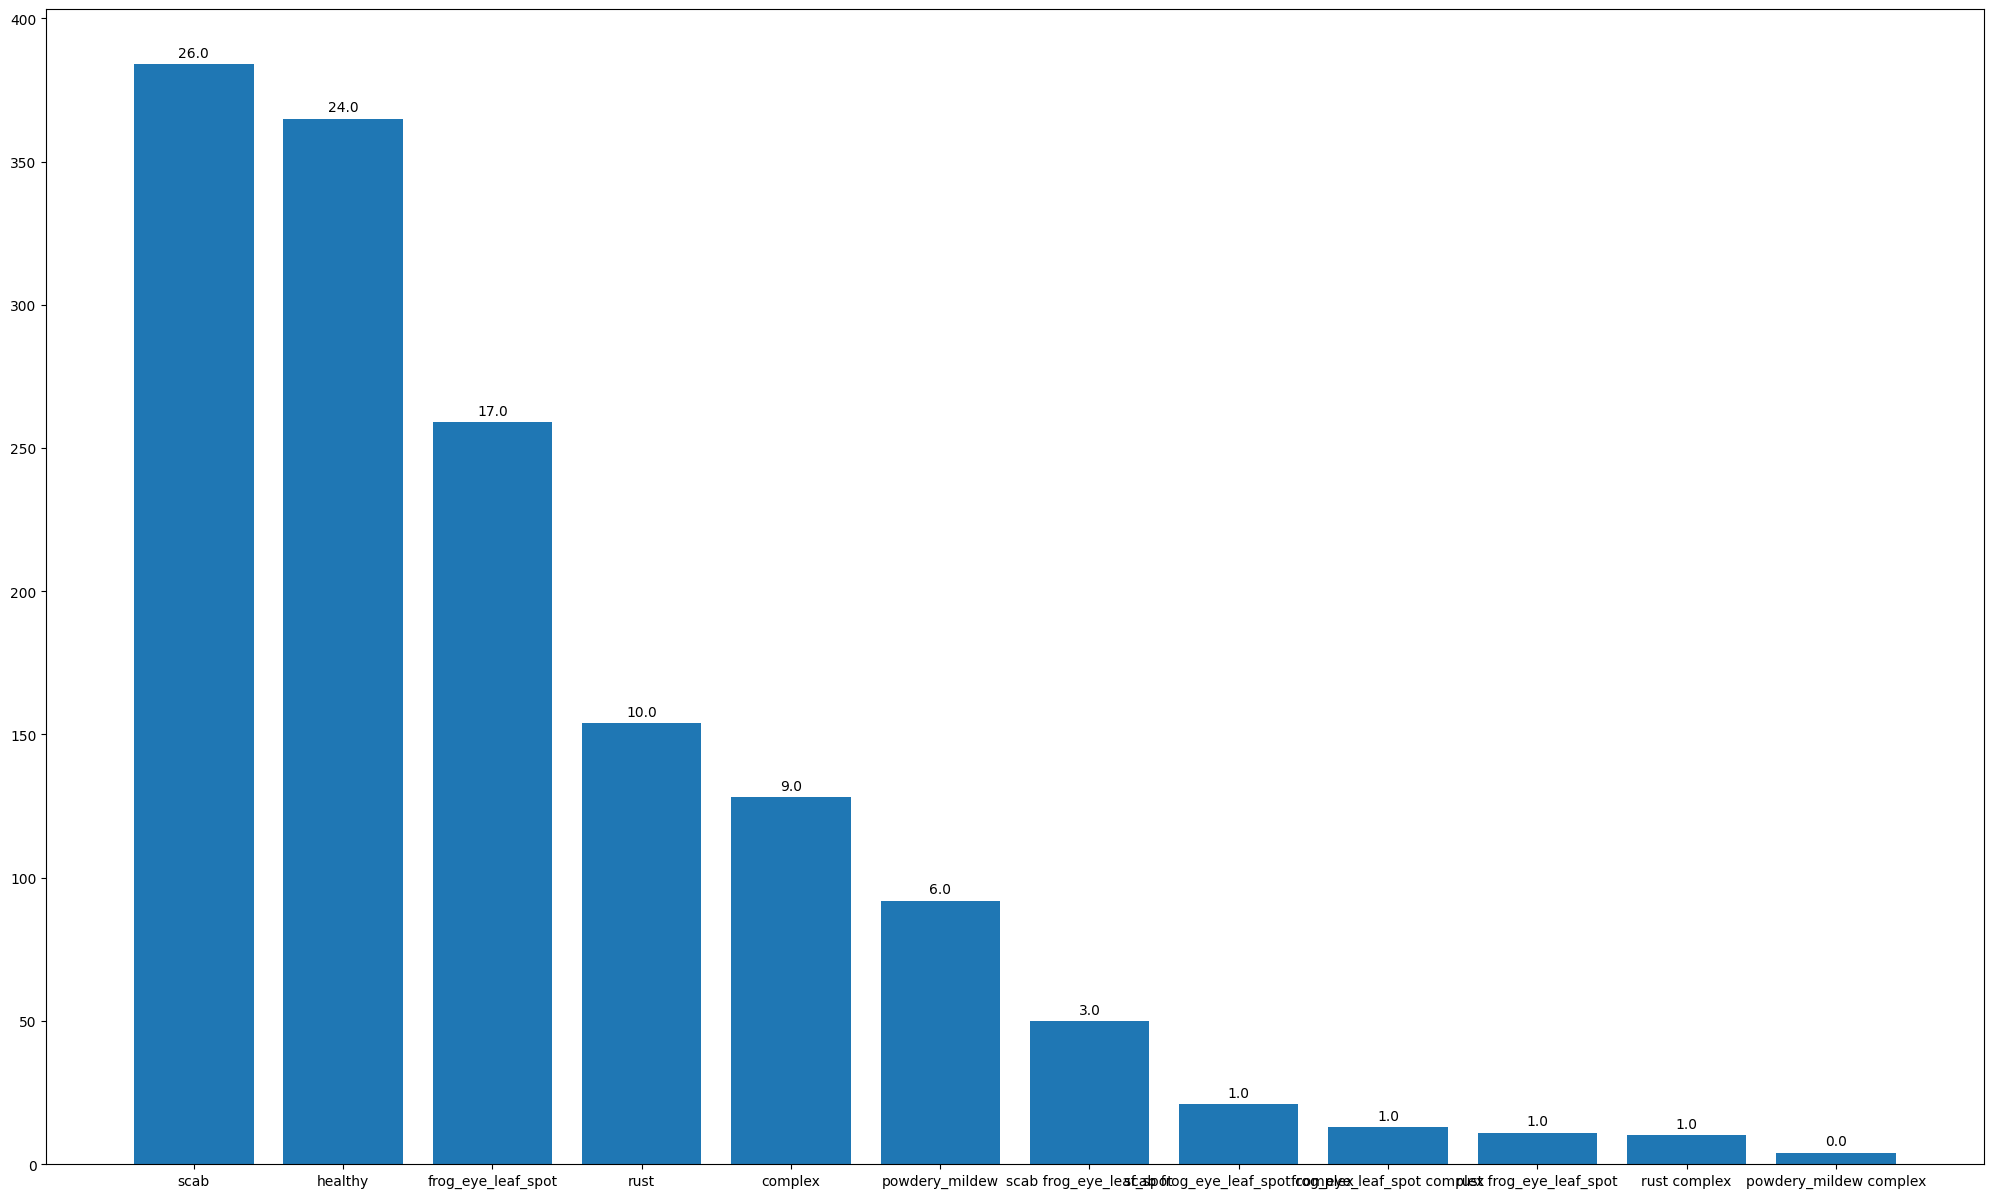

In [110]:
plot_grpahs(test)

In [122]:
tf.one_hot(3, depth=4)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 0., 1.], dtype=float32)>

In [126]:
train.head()

,image,labels,updated_paths,labels_encoded
7563,b58ac089edbd2eb0.jpg,healthy,../data/train_images/b58ac089edbd2eb0.jpg,3
8955,bfc002ff819f4b09.jpg,scab,../data/train_images/bfc002ff819f4b09.jpg,9
12865,d9e3cc33269f2708.jpg,rust,../data/train_images/d9e3cc33269f2708.jpg,6
8660,bdb5f66202366073.jpg,frog_eye_leaf_spot,../data/train_images/bdb5f66202366073.jpg,1
18504,ff83ac241bab48c6.jpg,frog_eye_leaf_spot,../data/train_images/ff83ac241bab48c6.jpg,1


In [152]:
len(train_csv['labels'].value_counts())

12

In [153]:
def read_train_imgs(img, label):
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size = (256, 256))
    img = img / 255
    label = tf.one_hot(label, depth = 12)
    return img, label

In [183]:
def get_data(**kwargs):
    imgs = kwargs['csv_file']['updated_paths'].values.tolist()
    labels = kwargs['csv_file']['labels_encoded'].values.tolist()
    tensor = tf.data.Dataset.from_tensor_slices((imgs, labels))
    tensor = tensor.cache()
    if kwargs['repeat']:
        tensor = tensor.repeat()
    if kwargs['shuffle']:
        tensor = tensor.shuffle(1024 * REPLICAS)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        tensor = tensor.with_options(opt)
    tensor = tensor.map(read_train_imgs, num_parallel_calls = AUTO)
    if kwargs['batch']:
        tensor = tensor.batch(kwargs['batch_size'] * REPLICAS)
    if kwargs['prefetch']:
        tensor = tensor.prefetch(AUTO)
    return tensor

In [187]:
args_dict = {
    'csv_file' : train,
    'repeat' : True,
    'shuffle' : True,
    'batch' : True,
    'batch_size' : 32,
    'prefetch' : True
}
train_dataset = get_data(**args_dict)